In [15]:
import pandas as pd 
from sklearn.utils import class_weight
from tqdm import tqdm

In [2]:
df = pd.read_csv('/run/media/twoaday/data-storag/data-sets/fashion-product-images-small/styles.csv', error_bad_lines=False)
df = df.dropna()

b'Skipping line 6044: expected 10 fields, saw 11\nSkipping line 6569: expected 10 fields, saw 11\nSkipping line 7399: expected 10 fields, saw 11\nSkipping line 7939: expected 10 fields, saw 11\nSkipping line 9026: expected 10 fields, saw 11\nSkipping line 10264: expected 10 fields, saw 11\nSkipping line 10427: expected 10 fields, saw 11\nSkipping line 10905: expected 10 fields, saw 11\nSkipping line 11373: expected 10 fields, saw 11\nSkipping line 11945: expected 10 fields, saw 11\nSkipping line 14112: expected 10 fields, saw 11\nSkipping line 14532: expected 10 fields, saw 11\nSkipping line 15076: expected 10 fields, saw 12\nSkipping line 29906: expected 10 fields, saw 11\nSkipping line 31625: expected 10 fields, saw 11\nSkipping line 33020: expected 10 fields, saw 11\nSkipping line 35748: expected 10 fields, saw 11\nSkipping line 35962: expected 10 fields, saw 11\nSkipping line 37770: expected 10 fields, saw 11\nSkipping line 38105: expected 10 fields, saw 11\nSkipping line 38275: ex

In [3]:
df.loc[df.usage == 'Smart Casual'].head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
1104,27870,Women,Apparel,Topwear,Shirts,White,Fall,2012.0,Smart Casual,Scullers For Her Women White Striped Shirt
4263,11324,Men,Apparel,Bottomwear,Trousers,Black,Fall,2011.0,Smart Casual,United Colors of Benetton Men Black and Brown ...
5860,20715,Men,Footwear,Shoes,Casual Shoes,Black,Winter,2018.0,Smart Casual,Red Tape Men Black Leather Casual Shoes
6440,59986,Women,Apparel,Dress,Dresses,Black,Fall,2012.0,Smart Casual,Avirate Women Black Dress
6486,46536,Men,Accessories,Watches,Watches,Black,Winter,2016.0,Smart Casual,Timex Men Black Dial Watch


In [4]:
df.groupby('usage').count()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,productDisplayName
usage,,,,,,,,,
Casual,34397,34397,34397,34397,34397,34397,34397,34397,34397
Ethnic,3208,3208,3208,3208,3208,3208,3208,3208,3208
Formal,2345,2345,2345,2345,2345,2345,2345,2345,2345
Home,1,1,1,1,1,1,1,1,1
Party,29,29,29,29,29,29,29,29,29
Smart Casual,67,67,67,67,67,67,67,67,67
Sports,4004,4004,4004,4004,4004,4004,4004,4004,4004
Travel,26,26,26,26,26,26,26,26,26


In [5]:
df.loc[df.usage == 'usage']

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName


In [6]:
classes = sorted(df.usage.unique())
weights = class_weight.compute_class_weight('balanced', classes, df.usage)
list(zip(classes, weights))

[('Casual', 0.16017748640869844),
 ('Ethnic', 1.7174641521197007),
 ('Formal', 2.3495202558635393),
 ('Home', 5509.625),
 ('Party', 189.98706896551724),
 ('Smart Casual', 82.23320895522389),
 ('Sports', 1.3760302197802199),
 ('Travel', 211.90865384615384)]

In [7]:
df.usage = df.usage.replace({'Smart Casual': 'Casual'})
df.usage = df.usage.replace({'Home': 'Other', 'Travel': 'Other', 'Party': 'Other'})
df.groupby('usage').count()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,productDisplayName
usage,,,,,,,,,
Casual,34464,34464,34464,34464,34464,34464,34464,34464,34464
Ethnic,3208,3208,3208,3208,3208,3208,3208,3208,3208
Formal,2345,2345,2345,2345,2345,2345,2345,2345,2345
Other,56,56,56,56,56,56,56,56,56
Sports,4004,4004,4004,4004,4004,4004,4004,4004,4004


In [8]:
classes = sorted(df.usage.unique())
weights = class_weight.compute_class_weight('balanced', classes, df.usage)
list(zip(classes, weights))

[('Casual', 0.255785747446611),
 ('Ethnic', 2.747942643391521),
 ('Formal', 3.759232409381663),
 ('Other', 157.41785714285714),
 ('Sports', 2.201648351648352)]

Using TensorFlow backend.


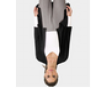

In [9]:
import matplotlib.image as mpimg
import imgaug.augmenters as iaa
import numpy as np

from keras.preprocessing import image
from commons.image_utils import scale_image

from PIL import Image

aug = iaa.Sequential([
        iaa.Crop(px=(0, 16)),  # crop images from each side by 0 to 16px (randomly chosen)
        iaa.Fliplr(0.5),  # horizontally flip 50% of the images
        iaa.Flipud(0.5),  # vertically flip 50% of the images
        iaa.GaussianBlur(sigma=(0., 2.))  # blur images with a sigma of 0 to 3.0
])

f = open('/run/media/twoaday/data-storag/data-sets/fashion-product-images-small/images/1165.jpg', 'rb')
f = Image.open(f)
f = scale_image(f, [96, 96])
f = np.asarray(f)
img_data = image.img_to_array(f)
img_data = np.expand_dims(img_data, axis=0)
img_data = img_data.astype('float32') / 255.
img_data = np.clip(img_data, 0., 1.)
img_data = img_data[0]
img_data = aug.augment_image(img_data)
# Creates PIL image
img = Image.fromarray(np.uint8(img_data * 255))
img

In [10]:
df.groupby('baseColour').count().sort_values(by='id', ascending=False)

,id,gender,masterCategory,subCategory,articleType,season,year,usage,productDisplayName
baseColour,,,,,,,,,
Black,9700,9700,9700,9700,9700,9700,9700,9700,9700
White,5497,5497,5497,5497,5497,5497,5497,5497,5497
Blue,4907,4907,4907,4907,4907,4907,4907,4907,4907
Brown,3440,3440,3440,3440,3440,3440,3440,3440,3440
Grey,2735,2735,2735,2735,2735,2735,2735,2735,2735
Red,2434,2434,2434,2434,2434,2434,2434,2434,2434
Green,2103,2103,2103,2103,2103,2103,2103,2103,2103
Pink,1824,1824,1824,1824,1824,1824,1824,1824,1824
Navy Blue,1784,1784,1784,1784,1784,1784,1784,1784,1784


In [11]:
df.baseColour = df.baseColour.replace({'Lime Green': 'Green', 
                                       'Fluorescent Green': 'Green', 
                                       'Sea Green': 'Green',
                                       'Mushroom Brown':'Brown',
                                       'Coffee Brown':'Brown',
                                       'Bronze':'Brown',
                                       'Copper':'Brown',
                                       'Rose': 'Red',
                                       'Burgundy':'Purple',
                                        'Metallic':'Grey',
                                       'Mustard':'Yellow',
                                        'Nude': 'Beige',
                                       'Taupe': 'Grey',
                                       'Mauve':'Pink',
                                       'Turquoise Blue':'Teal',
                                       'Maroon':'Red',
                                       'Rust':'Orange',
                                       'Skin': 'Beige',
                                       'Tan': 'Beige',
                                      'Off White': 'White'})

In [12]:
classes = sorted(df.baseColour.unique())
weights = class_weight.compute_class_weight('balanced', classes, df.baseColour)
list(zip(classes, weights))

[('Beige', 1.6285007019877338),
 ('Black', 0.17477002379064235),
 ('Blue', 0.3454797698734931),
 ('Brown', 0.46356828842472814),
 ('Charcoal', 7.435391363022942),
 ('Cream', 4.414763621794871),
 ('Gold', 2.729902142945621),
 ('Green', 0.794037110430553),
 ('Grey', 0.6082774419695841),
 ('Grey Melange', 11.611433087460485),
 ('Khaki', 12.196181516325401),
 ('Lavender', 10.595432692307693),
 ('Magenta', 13.244290865384615),
 ('Multi', 4.302713783678251),
 ('Navy Blue', 0.9502630217316316),
 ('Olive', 4.1449125446680455),
 ('Orange', 2.8831109366823653),
 ('Peach', 9.163617463617463),
 ('Pink', 0.9153721548429972),
 ('Purple', 1.023713303604608),
 ('Red', 0.5591257357418308),
 ('Silver', 1.5567210567210568),
 ('Steel', 5.381807081807082),
 ('Teal', 9.017389525368248),
 ('White', 0.29851544827773036),
 ('Yellow', 1.9418891532293594)]

In [21]:
def category_extractor(row):
    if row['subCategory'] in ['Topwear', 'Dress', 'Headwear', 'Innerwear']:
        if len(df.loc[df.articleType == str(row['articleType'])]) >= 800:
            return str(row['articleType'])    
    if row['subCategory'] in ['Bottomwear', 'Shoes'] and len(df.loc[df.articleType == str(row['articleType'])]) >= 300:
        return str(row['articleType'])    
    return str(row['subCategory'])


exclude_list = ['Vouchers', 'Home Furnishing', 'Umbrellas', 'Water Bottle', 'Bath and Body',
                'Shoe Accessories', 'Sports Accessories', 'Sports Equipment', 'Free Gifts',
                'Cufflinks', 'Apparel Set', 'Cufflinks', 'Green', 'Wristbands']
tqdm.pandas()

df['subCategory'] = df.progress_apply(lambda row: category_extractor(row), axis=1)

for exclude in exclude_list:
    df = df.loc[df.subCategory != exclude]

df.subCategory = df.subCategory.replace({'Perfumes': 'Green',
                                         'Lips': 'Cosmetic',
                                         'Eyes': 'Cosmetic',
                                         'Sandals': 'Sandal',
                                         'Skin Care': 'Cosmetic',
                                         'Makeup': 'Cosmetic',
                                         'Skin': 'Cosmetic',
                                         'Hair': 'Cosmetic',
                                         'Nails': 'Cosmetic',
                                         'Beauty Accessories': 'Cosmetic',
                                         'Mufflers': 'Scarves',
                                         'Stoles': 'Scarves'
                                         })

df.groupby('subCategory').count().sort_values(by='id', ascending=False)

100%|██████████| 43639/43639 [00:09<00:00, 4840.94it/s]


,id,gender,masterCategory,articleType,baseColour,season,year,usage,productDisplayName
subCategory,,,,,,,,,
Tshirts,7065,7065,7065,7065,7065,7065,7065,7065,7065
Shirts,3214,3214,3214,3214,3214,3214,3214,3214,3214
Bags,3053,3053,3053,3053,3053,3053,3053,3053,3053
Casual Shoes,2845,2845,2845,2845,2845,2845,2845,2845,2845
Watches,2542,2542,2542,2542,2542,2542,2542,2542,2542
Sports Shoes,2016,2016,2016,2016,2016,2016,2016,2016,2016
Kurtas,1844,1844,1844,1844,1844,1844,1844,1844,1844
Tops,1762,1762,1762,1762,1762,1762,1762,1762,1762
Topwear,1499,1499,1499,1499,1499,1499,1499,1499,1499


In [14]:
df.loc[df.subCategory == 'Green'].sample()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
10171,44030,Men,Personal Care,Green,Perfume and Body Mist,Orange,Spring,2017.0,Casual,dunhill Men Pursuit Perfume
